In [16]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import scipy.stats as stats

# A/B - тестирование

Считываем  сsv-файлы в три DataFrame и смотрим: типы данных в таблицах, есть ли пропущенные данные.

In [97]:
df1 = pd.read_csv('active_studs.csv')

In [98]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8341 entries, 0 to 8340
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   student_id  8341 non-null   int64
dtypes: int64(1)
memory usage: 65.3 KB


In [99]:
df1.head()

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


In [100]:
df2 = pd.read_csv('checks.csv',sep=';')

In [101]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   student_id  541 non-null    int64  
 1   rev         541 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 8.6 KB


In [102]:
df2.describe()

,student_id,rev
count,5.410000e+02,541.000000
mean,2.514772e+06,1059.752317
std,1.726839e+06,762.712359
min,1.627000e+03,199.000000
25%,9.871290e+05,290.000000
50%,2.526021e+06,840.000000
75%,3.993249e+06,1900.000000
max,5.740903e+06,4650.000000


In [103]:
df3 = pd.read_csv('groups.csv',skiprows=1,sep=';', names=['student_id','group'])

In [104]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74576 entries, 0 to 74575
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   student_id  74576 non-null  int64 
 1   group       74576 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


In [105]:
df3.head()

,student_id,group
0,1206794,B
1,331024,B
2,1733498,A
3,161574,B
4,168443,B


Все ок. Соединяем три таблицы в одну: active_studs <- groups <- checks. Заменяем null на 0 в столбце с оплатами, проверяем, что нет активных пользователей без группы.

In [106]:
data = pd.merge(df1, df3, how='left', on=['student_id', 'student_id'])
data1 = pd.merge(data, df2, how='left', on=['student_id', 'student_id'])
data1.fillna(0, inplace = True)
data1.group.unique()

array(['A', 'B'], dtype=object)

In [107]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8341 entries, 0 to 8340
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   student_id  8341 non-null   int64  
 1   group       8341 non-null   object 
 2   rev         8341 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 260.7+ KB


In [111]:
ex_a = data1[(data1['group'] == 'A') & (data1['rev'] != 0)]['rev'].tolist()
ex_b = data1[(data1['group'] == 'B') & (data1['rev'] != 0)]['rev'].tolist()

In [112]:
ARPU = [sum(ex_a)/ count_a, sum(ex_b)/count_b]
ARPPU = [sum(ex_a)/len(ex_a), sum(ex_b)/len(ex_b)]
CR = [len(ex_a)/count_a, len(ex_b)/count_b]
print(ARPU)
print(ARPPU)
print(CR)

[47.34720416124838, 58.05879810377777]
[933.5897435897435, 1257.8789920382171]
[0.05071521456436931, 0.046156107599588415]


In [113]:
fig = go.Figure(go.Funnel(
    y = ["Control_group_A","Visit", "Success_pay"],
    x = [len(df3[df3['group'] == 'A']),len(data1[data1['group'] == 'A']), len(ex_a)],
    textposition = "inside",
    textinfo = "value+percent initial",
    opacity = 0.65, marker = {"color": ["darkblue", "blue", "skyblue"]}))
fig.show()

fig = go.Figure(go.Funnel(
    y = ["Test_group_B","Visit", "Success_pay"],
    x = [len(df3[df3['group'] == 'B']),len(data1[data1['group'] == 'B']), len(ex_b)],
    textposition = "inside",
    textinfo = "value+percent initial",
    opacity = 0.65, marker = {"color": ["darkblue", "blue", "skyblue"]}))
fig.show()

Построили воронку для котрольной группы А по трем группам: 1)пользователи из группы А, 2)посетившие платформу и 3)оплатившие товар.
То же самое проделали для тестовой группы В.
##### Получили следующие конверсии:
Из группы А посетили платформу только 10.5% пользователей, а из группы В - 11.4% пользователей.
В группе А решились оплатить заказ 5.1%, в группе В - 4.6%. От общего числа пользователей для каждой группы это составляет 0.5%
### Вывод:
Между новой и старой механикой ощутимой разницы нет: доля покупателей осталась прежней. 
Поэтому далее смотрим, повлияла ли новая механика на размер оплаты пользователей.

## Проверка гипотез

Возьмем две выборки с оплатами контрольной группы А и тестовой группы В.
Сформулируем нулевую и альтернативную гипотезы для этих групп:

* H0 - нет значимой разницы между значениями оплат в группах;
* H1 - есть значимая разница между оплатами в группах.


Text(0.5, 1.0, 'test')

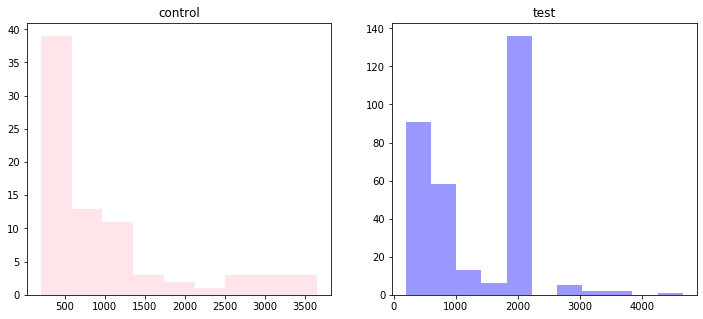

In [114]:
f= plt.figure(figsize=(12,5))

ax=f.add_subplot(121)
sns.distplot(ex_a,color = 'pink',hist = True,kde = False, ax = ax)
ax.set_title('control')

ax=f.add_subplot(122)
sns.distplot(ex_b,color = 'blue',hist = True, kde = False, ax=ax)
ax.set_title('test')


**Проверим данные на нормальность**

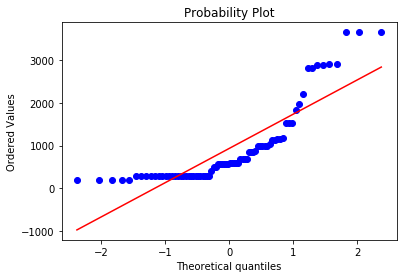

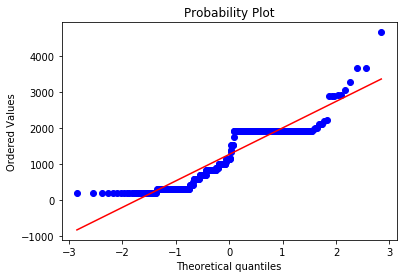

In [115]:
stats.probplot(ex_a, dist="norm", plot=plt)
plt.show()

stats.probplot(ex_b, dist="norm", plot=plt)
plt.show()

Оплаты распределены не нормально, группы у нас независимы, поэтому можем использовать непараметрический критерий Манна-Уитни.
Уровень значимости возьмем 0.05, двусторонняя критическая область:

In [116]:
stat, p_val = stats.mannwhitneyu(ex_a,ex_b,alternative = 'two-sided')
if p_val > 0.05:
    print('Статистически значимой разницы нет','\np-value',round(p_val,4),'\nU-критерий',stat)
else:
    print('Разница статистически значима','\np-value',round(p_val,4),'\nU-критерий',stat)

Разница статистически значима 
p-value 0.0003 
U-критерий 9001.0


**Значит, отвергаем нулевую гипотезу!**
Есть статистически значимая разница между оплатами, поэтому подробнее изучим их.

#### Тогда сравним метрики ARPU, ARPPU и еще раз вспомним про конверсию (задание **Python ** )

In [117]:
def ab_test_results(groups, active_studs, checks):
    data = pd.merge(active_studs, groups, how='left', on=['student_id', 'student_id'])
    data1 = pd.merge(data, checks, how='left', on=['student_id', 'student_id'])
    data1.fillna(0, inplace = True)
    ex_a = data1[(data1['group'] == 'A') & (data1['rev'] != 0)]['rev'].tolist()
    ex_b = data1[(data1['group'] == 'B') & (data1['rev'] != 0)]['rev'].tolist()
    count_b, count_a = data1['group'].value_counts()
    ARPU = [sum(ex_a)/count_a, sum(ex_b)/count_b]
    ARPPU = [sum(ex_a)/len(ex_a), sum(ex_b)/len(ex_b)]
    CR = [len(ex_a)/count_a, len(ex_b)/count_b]
    
    city = ['ARPU','ARPPU']

    fig = go.Figure()
    fig.add_trace(go.Bar(
        x=city,
        y=[sum(ex_a)/ count_a, sum(ex_a)/len(ex_a), len(ex_a)/count_a*100],
        name='A',
        marker_color='blue'
    ))
    fig.add_trace(go.Bar(
        x=city,
        y=[sum(ex_b)/count_b, sum(ex_b)/len(ex_b), len(ex_b)/count_b*100],
        name='B',
        marker_color='lightgreen'
    ))
    fig.update_layout(barmode='group')
    fig.update_layout(title_text='Метрики ARPU, ARPPU')
    fig.show()
    
    fig = go.Figure()
    fig.add_trace(go.Bar(
        x=['CR'],
        y=[len(ex_a)/count_a*100],
        name='A',
        marker_color='blue'
    ))
    fig.add_trace(go.Bar(
        x=['CR'],
        y=[len(ex_b)/count_b*100],
        name='B',
        marker_color='lightgreen'
    ))
    
    fig.update_layout(barmode='group')
    fig.update_layout(title_text='Конверсия в покупку')
    fig.show()
    
    return 

In [118]:
ab_test_results(df3,df1,df2)

### Выводы:
1. При тестировании новый механики доход на пользователя увеличился (см. ARPU). Это означает, что пользователя нововведения не отпугнули.
2. ARPPU — это доход на одного платящего пользователя. Платящих всегда меньше, поэтому этот показатель всегда выше ARPU. 
ARPPU показывает реакцию платящих пользователей на ценность продукта. Можем сделать вывод по столбчатой диаграмме, что ценность продукта возросла с новой механикой: пользователь охотнее тратит свои средства на покупку в тестовой, чем в контрольной группе.
3. Доля конверсий в покупку незназначительно меньше у тестовой группы, чем у контрольной. То есть смысл оставить новую механику, так как она улучшила ARPPU, но подумать над привлечением и стимулированием к покупке остальных пользователей. Например, переработать тарифную сетку и изменить цены: выделили разные тарифы для разных клиентов с определённными наборами функций.

# SQL

* 2.1       Ответ: вывод 1)

In [119]:
pd.DataFrame({"count(1)":[5],"count(f2)":[3],"sum(f1)":[10],"sum(f1) filter (where f1=f2)":[5]})

,count(1),count(f2),sum(f1),sum(f1) filter (where f1=f2)
0,5,3,10,5


вывод 2)

In [120]:
pd.DataFrame({"count(1)":[5],"count(f2)":[3]})

,count(1),count(f2)
0,5,3


* 2.2 Так как не указана СУБД, то немного читерства и запрос в ClickHouse:

select toDayofMounth(sale_time) as day,

       test_grp as test_group,
       sum(money)/count(st_id) as ARPU,
       countIf(st_id, money > 0)/count(st_id) as CR,
        countIf(st_id, money > 0 and subject = 'math')/count(st_id) as CR_math,
from studs left join checks on studs.st_id = checks.st_id
where sale_time between '2020-06-01' and '2020-06-30'
group by day, test_group;